### Cheking if we are in google colab or not.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install geemap
    !pip install geedim

In [3]:
import ee
import geemap

In [4]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from skimage import io
import numpy as np
import ee
import geemap
import logging
import multiprocessing
import os
import requests
import shutil
# from retry import retry
from datetime import datetime
import matplotlib.pyplot as plt

from collections import namedtuple

In [5]:
from utils.utils import *
from utils.ee_utils import *
from utils.ee_utils import TextColors as tc

4/1AfgeXvvmWF-_z0qOvwsZK597gUnHMOdSTjpY6CStI-buWxqNvRlGoRU19og

In [6]:
Map = geemap.Map()

In [7]:
#ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
ee.Initialize()

# A Function to retrive S1 and S2

has two inputs:
*   date
*   roi


Returns:
*   s1
*   s2 image




In [8]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

---

### add to current time
used [this doc ](https://bobbyhadz.com/blog/python-add-months-to-date#:~:text=Use%20the%20relativedelta%20class%20from,with%20different%20numbers%20of%20days.)

we use this function to to expand the time span we are searching for `S2` images, if the S2 mosaic was not coplete in the month we want, it increases the span.

In [9]:
date_time_obj = datetime.strptime('2020-01-02', '%Y-%m-%d')
new_date_time_obj= date_time_obj + relativedelta(months=+3)
print(new_date_time_obj)
print(new_date_time_obj.strftime('%Y-%m-%d'))
print(type(new_date_time_obj.strftime('%Y-%m-%d')))

2020-04-02 00:00:00
2020-04-02
<class 'str'>


### the idea behind buffering
so s2 images an area evry five days, so the sampling rate is 5 days, so if we find an snowy s2 image we assume that the whole five days which is 2 days before and 2 days after, are snowy, we add all these days into a list, as snowy days to later check s1 images and remove those that have the same date as this list.

# OSCD Dataset ROIs

## aguasclaras

In [10]:
from rois import ROIS
rois = ROIS()
roi = rois.bercy

In [11]:
features = geemap.fishnet(roi, rows=2, cols=2, delta=0.1)
#features = geemap.fishnet(roi, h_interval=0.05, v_interval=0.05)

In [12]:
Map = geemap.Map(zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayer(roi)

# Map.addLayer(abudhabi,{'color': 'fc0303'})
# Map.addLayer(aguasclaras,{'color': 'fc5e03'})
# Map.addLayer(beihai,{'color': 'fcad03'})
# Map.addLayer(beirut,{'color': 'fce303'})
# Map.addLayer(bercy,{'color': 'c6fc03'})
# Map.addLayer(bordeaux,{'color': '7bfc03'})
# Map.addLayer(brasilia,{'color': '35fc03'})
# Map.addLayer(chongqing,{'color': '03fc80'})
# Map.addLayer(cupertino,{'color': '03fcc6'})
# Map.addLayer(dubai,{'color': '03fce3'})
# Map.addLayer(hongkong,{'color': '03dffc'})
# Map.addLayer(lasvegas,{'color': '0394fc'})
# Map.addLayer(milano,{'color': '0362fc'})
# Map.addLayer(montpellier,{'color': '0318fc'})
# Map.addLayer(mumbai,{'color': '5a03fc'})
# Map.addLayer(nantes,{'color': '9803fc'})
# Map.addLayer(norcia,{'color': 'c203fc'})
# Map.addLayer(paris,{'color': 'fc03f4'})
# Map.addLayer(pisa,{'color': 'fc03ce'})
# Map.addLayer(rennes,{'color': 'fc03a5'})
# Map.addLayer(rio,{'color': 'fc036f'})
# Map.addLayer(saclay_e,{'color': 'fc0345'})
# Map.addLayer(saclay_w,{'color': 'fc032d'})
# Map.addLayer(valencia,{'color': 'fc0303'})

# Map.addLayer(features, {}, 'Grids')
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [13]:
# 'ASCENDING'
# 'DESCENDING'
s2_col,s1_col = s1s2(roi,date = ('2021-07-15', '2021-08-15'),priority_path = 'DESCENDING',max_cloud = 100,max_snow = 100,month_span = 1,retry_days=0)
# s2_col,s1_col_desc = s1s2(roi,date = ('2020-08-10', '2020-09-20'),priority_path = 'DESCENDING',max_cloud = 5)

 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-31
final date range:   2021-06-30 2021-08-31 | diff_days -> 62 
◍checking for DESCENDING single scene
Mosiac Covers 95.00540248471052 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 


In [14]:
sen2_print(s2_col)

,Property,0,1,2,3,4,5,6,7,8,9,10,11
0,system:time_start,2021-07-17,2021-07-19,2021-07-22,2021-07-24,2021-07-27,2021-07-29,2021-08-01,2021-08-03,2021-08-06,2021-08-08,2021-08-11,2021-08-13
1,roi_cloud_cover,95.603929,0.060864,0.121729,55.209862,95.603929,38.935949,34.878570,95.603929,95.543064,13.333572,42.624802,7.292495
2,CLOUDY_PIXEL_PERCENTAGE,91.437759,2.355076,0.408007,91.405566,98.069242,51.998403,41.787647,87.877446,85.708293,40.412823,54.434299,16.812056
3,CLOUD_SHADOW_PERCENTAGE,0.234356,0.077020,0.250338,0.041675,0,5.188723,6.418061,0.403764,0.173201,4.507200,3.396637,0.507126
4,VEGETATION_PERCENTAGE,3.170934,60.976559,59.382445,2.410075,0,21.865638,24.929944,3.434381,3.169664,26.205105,22.549260,49.780741
5,NOT_VEGETATED_PERCENTAGE,0.908962,35.378841,38.356686,2.211741,0.029859,13.423601,17.290862,1.420878,2.435716,14.814843,12.481698,29.063180
6,CLOUD_COVERAGE_ASSESSMENT,91.437759,2.355076,0.408007,91.405566,98.069242,51.998403,41.787647,87.877446,85.708293,40.412823,54.434299,16.812056
7,GENERATION_TIME,1626531140000,1626888199000,1626958595000,1627135119000,1627396094000,1627843878000,1627823281000,1627999643000,1628258833000,1628431847000,1628693377000,1628863429000
8,SENSING_ORBIT_NUMBER,94,51,94,51,94,51,94,51,94,51,94,51
9,NODATA_PIXEL_PERCENTAGE,26.479939,0.000056,26.772150,0,26.462221,0.000013,26.741484,0,26.404715,0.000040,26.570237,0.000109


In [15]:
sen1_print(s1_col.sort('system:time_start')) #.filter(ee.Filter.eq('relativeOrbitNumber_start', 30))

,Property,0,1,2,3,4,5,6,7,8,9
0,system:time_start,2021-07-02,2021-07-08,2021-07-14,2021-07-20,2021-07-26,2021-08-01,2021-08-07,2021-08-13,2021-08-19,2021-08-25
1,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
2,resolution,H,H,H,H,H,H,H,H,H,H
3,resolution_meters,10,10,10,10,10,10,10,10,10,10
4,platform_number,B,A,B,A,B,A,B,A,B,A
5,productType,GRD,GRD,GRD,GRD,GRD,GRD,GRD,GRD,GRD,GRD
6,orbitNumber_start,27611,38682,27786,38857,27961,39032,28136,39207,28311,39382
7,orbitNumber_stop,27611,38682,27786,38857,27961,39032,28136,39207,28311,39382
8,transmitterReceiverPolarisation,"['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']"
9,system:band_names,"['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']","['VV', 'VH', 'angle']"


In [16]:
vis_params_s2 = {
  'min': 0.04,
  'max': 0.4,
  'bands': ['B4', 'B3', 'B2'],
}

# un comment this for Band 8 to be added to the map so you can check the correlation between NIR and radar backscatter

# vis_params_s2 = {
#   'min': 0.04,
#   'max': 0.4,
#   'bands': ['B8'],
# }

vis_params_s1_dark = {
    'min': -18,
    'max': -2,
    'bands': ['VV_db']
}

# vis params for dense urban structure, comment if images is too dark. (so the above one gets applied)
vis_params_s1_bright = {
    'min': -10,
    'max': 10,
    'bands': ['VV_db']
}

## To Linear and back again!
as was said in the `Woodhouse pg. 324` we cannot averasge over `db` values.
so we convert the data into `linear` scale, then we use `.mean()` method

In [17]:
s1_col = s1_col.map(toLinear)

In [18]:
sen1_print(s1_col)

,Property,0,1,2,3,4,5,6,7,8,9
0,system:time_start,2021-07-08,2021-07-20,2021-08-01,2021-08-13,2021-08-25,2021-07-02,2021-07-14,2021-07-26,2021-08-07,2021-08-19
1,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
2,resolution,H,H,H,H,H,H,H,H,H,H
3,resolution_meters,10,10,10,10,10,10,10,10,10,10
4,platform_number,A,A,A,A,A,B,B,B,B,B
5,productType,GRD,GRD,GRD,GRD,GRD,GRD,GRD,GRD,GRD,GRD
6,orbitNumber_start,38682,38857,39032,39207,39382,27611,27786,27961,28136,28311
7,orbitNumber_stop,38682,38857,39032,39207,39382,27611,27786,27961,28136,28311
8,transmitterReceiverPolarisation,"['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']","['VV', 'VH']"
9,system:band_names,"['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']","['VV', 'VH', 'angle', 'VV_lin']"


In [19]:
s1_img = s1_col.mean().clip(roi)
s1_img = toDb(s1_img)
s2_img = s2_col.median().clip(roi).multiply(0.0001)

fetching an image from a list with index

https://gis.stackexchange.com/questions/419477/google-earth-engine-selecting-one-image-from-imagecollection

In [20]:
# s2_col_list=ee.ImageCollection(s2_col).toList(999)
# s2_img=ee.Image(ee.List(s2_col_list).get(1)).multiply(0.0001) #index zero is the first image.

In [21]:
left_layer = geemap.ee_tile_layer(s1_img, vis_params_s1_bright, 'S1')
right_layer = geemap.ee_tile_layer(s2_img, vis_params_s2, 'S2')

** Comparing Sentinel 1a and 1b images (we used roi:paris) **

In [22]:
# left_layer = geemap.ee_tile_layer(s1_img, vis_params_s1, 'S1')
# right_layer = geemap.ee_tile_layer(s1_col_desc.mean().clip(roi), vis_params_s1, 'S2')

In [23]:
#just checking the how good is avaraging in spackle removal

# s2_img = s1_col_1m.mean().clip(roi)
# right_layer = geemap.ee_tile_layer(s2_img, vis_params_s1, 'S2')

### Folliom
when I use center object roi it takes some time to zoom in, the work around is to used `zoom` argument in the `Map = geemap.Map(zoom=12)` this way, the map is already zoomed in and this way you can buy yourself some time.

In [24]:
Map = geemap.Map(zoom=12)
Map.centerObject(roi)
Map.split_map(left_layer, right_layer)
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Sentinel 2 Surface Reflectance band 10
band 10 is cirus and is available in TOA data, and is used for atmospheric correction, therfore it is not in the SR img.

In [25]:
bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']

In [26]:
s1_img_vv = s1_img.select('VV_db')
s2_img_13b = s2_img.select(bands)

In [27]:
print(s1_img_vv.bandNames().getInfo())
print(s2_img_13b.bandNames().getInfo())

['VV_db']
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


In [28]:
#geemap.download_ee_image(s1_img_vv, "s1.tif",crs='EPSG:4326', scale=10,region = roi)

In [29]:
#geemap.download_ee_image(s2_img_13b, "s2.tif",crs='EPSG:4326', scale=10,region = roi)

In [30]:
# ! du -sh /content/s2.tif
# ! du -sh /content/s1.tif

In [31]:
s1_np = io.imread('s1.tif')
s2_np = io.imread('s2.tif')

print(s1_np.shape)
print(s2_np.shape)

(512, 468)
(12, 512, 468)


In [32]:
print(np.min(s1_np),np.mean(s1_np),np.max(s1_np))
print(np.min(s2_np),np.max(s2_np))

-18.00359749308987 -3.0573955350116737 32.8557334290245
0.0287 0.8239500000000001


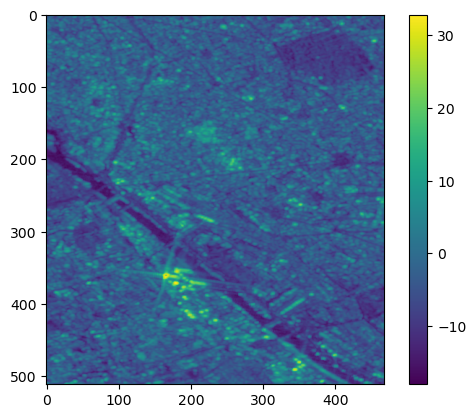

In [33]:
plt.imshow(s1_np)
plt.colorbar()

(array([[ 13.,  81., 216., ...,   0.,   0.,   0.],
        [ 14.,  86., 205., ...,   0.,   0.,   0.],
        [ 15.,  87., 197., ...,   0.,   0.,   0.],
        ...,
        [  2.,  62., 267., ...,   0.,   0.,   0.],
        [  3.,  66., 277., ...,   0.,   0.,   0.],
        [  4.,  57., 284., ...,   0.,   0.,   0.]]),
 array([-18.00359749, -12.9176644 ,  -7.83173131,  -2.74579822,
          2.34013488,   7.42606797,  12.51200106,  17.59793415,
         22.68386724,  27.76980034,  32.85573343]),
 <a list of 468 BarContainer objects>)

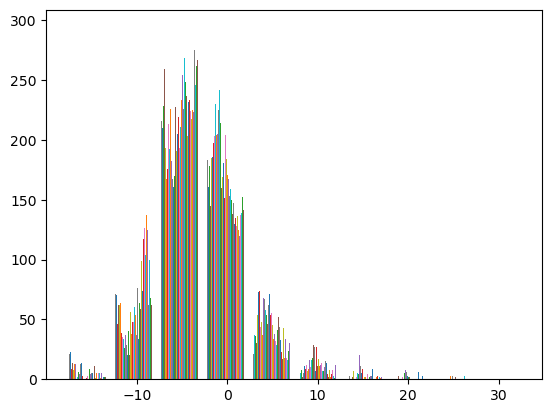

In [34]:
plt.hist(s1_np)

In [35]:
s2_np_swaped = np.swapaxes(s2_np,2,0)
s2_np_swaped = np.swapaxes(s2_np_swaped,1,0)
print(s2_np_swaped.shape)

(512, 468, 12)


In [36]:
s2_np_oneband = s2_np_swaped[:,:,1]
print(np.min(s2_np_oneband),np.max(s2_np_oneband))
# s2_np_oneband = s2_np_oneband/np.max(s2_np_oneband)
# s2_np_oneband = s2_np_oneband * 255
# s2_np_oneband = s2_np_oneband.astype('uint8')

0.04295 0.7344


(512, 468)


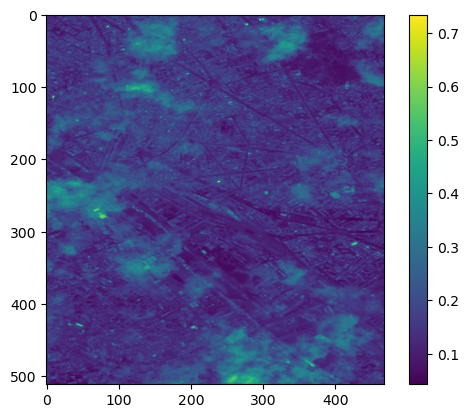

In [37]:
print(s2_np_oneband.shape)
plt.imshow(s2_np_oneband)
plt.colorbar()

# Downlaod All!

In [38]:
import pandas as pd
import ast
import collections
import os
import shutil

In [39]:
YEAR = 2021
Y = YEAR - 2000
rois_path = f'D:\python\TemporalGAN\dataset\\{Y}_ROIs.xlsx'
SR = False if YEAR == 2017 else True

In [40]:
df = pd.read_excel(rois_path)

## checking if there is a duplicate in the names

In [41]:
names = []
for index, row in df.iterrows():
    names.append(row['name']+str(row['year_type']))
print([item for item, count in collections.Counter(names).items() if count > 1])

[]


In [42]:
#shutil.rmtree('/content/s2_imgs/')  

In [43]:
# Consice info printing function
sen2_short_print = lambda s2_collection: ee_property_printer(s2_collection, propertie_name_list=['system:time_start','roi_cloud_cover', 'CLOUDY_PIXEL_PERCENTAGE',
                                                                                                            'system:band_names'],
                                                             first_is_t_in_millis=True, df_instead_of_print=False)

sen1_short_print = lambda s2_collection: ee_property_printer(s2_collection, propertie_name_list=['system:time_start','platform_number',
                                                                                           'system:band_names','instrumentMode',                         
                                                                                            'relativeOrbitNumber_stop','relativeOrbitNumber_start',
                                                                                            'cycleNumber'],
                                                             first_is_t_in_millis=True, df_instead_of_print=False)

### dataset downlaoder

In [44]:
import os

current_dir = os.getcwd()

print(current_dir)

d:\python\TemporalGAN\dataset


In [45]:
if IN_COLAB:
    S1_FOLDER_TRAIN = f'/content/{YEAR}/s1_imgs/train/'
    S1_FOLDER_TEST = f'/content/{YEAR}/s1_imgs/test/'
    S2_FOLDER_TRAIN = f'/content/{YEAR}/s2_imgs/train/'
    S2_FOLDER_TEST = f'/content/{YEAR}/s2_imgs/test/'
else:
    S1_FOLDER_TRAIN = f'./s1s2/{YEAR}/s1_imgs/train/'
    S1_FOLDER_TEST = f'./s1s2/{YEAR}/s1_imgs/test/'
    S2_FOLDER_TRAIN = f'./s1s2/{YEAR}/s2_imgs/train/'
    S2_FOLDER_TEST = f'./s1s2/{YEAR}/s2_imgs/test/'
# create folders if not exist
if not os.path.exists(S1_FOLDER_TRAIN) or not os.path.exists(S1_FOLDER_TEST) or not os.path.exists(S2_FOLDER_TRAIN) or not os.path.exists(S2_FOLDER_TEST):
    print("Creating folders...")
    os.makedirs(S1_FOLDER_TRAIN, exist_ok=True)
    os.makedirs(S1_FOLDER_TEST, exist_ok=True)
    os.makedirs(S2_FOLDER_TRAIN, exist_ok=True)
    os.makedirs(S2_FOLDER_TEST, exist_ok=True)

In [46]:
#df = df.iloc[24:]

In [47]:
bands = ['B2','B3','B4','B8','B11','B12']
for index, row in df.iterrows():
    print("🟢",tc.BOLD_BAKGROUNDs.PURPLE,row['name']+str(row['year_type']),tc.ENDC,"🟢")
    r_roi = ast.literal_eval(row['roi'])
    r_roi = ee.Geometry.Polygon(r_roi, None, False)
    r_date = ast.literal_eval(row['date'])
    r_pp =  row['priority_path']
    r_mc =  int(row['max_cloud'])
    r_ms =  int(row['max_snow'])
    r_ms =  int(row['month_span'])
    r_rd =  int(row['retry_days'])

    s2_col,s1_col = s1s2(r_roi , date = r_date , priority_path = r_pp , max_cloud =r_mc , max_snow = r_ms , month_span = r_ms ,retry_days = r_rd , sr = SR,best_orbit=True)
    s1_col = s1_col.map(toLinear) # convers dB values to Linear, and adds band 'VV_lin' to the images of the collection
    print(tc.OKCYAN,"---------------------------S2---------------------------",tc.ENDC)
    sen2_short_print(s2_col)
    print(tc.OKCYAN,"---------------------------S1---------------------------",tc.ENDC)
    sen1_short_print(s1_col)
    
    #=====================DOWNLOAD==========================
    # s1_img = s1_col.mean().clip(r_roi)
    # s1_img = toDb(s1_img) # reads the 'VV_lin' and returns the image with the added band 'VV_db' 
    # s2_img = s2_col.median().clip(r_roi).multiply(0.0001)

    # s1_img_vv = s1_img.select('VV_db')
    # s2_img_12b = s2_img.select(bands)
    
    # S1_FOLDER = S1_FOLDER_TRAIN if row['train_test'] == 'train' else S1_FOLDER_TEST
    # S2_FOLDER = S2_FOLDER_TRAIN if row['train_test'] == 'train' else S2_FOLDER_TEST
        
    # r_name = str(index+1).zfill(3) + '_' + row['name'] + str(row['year_type'])
    # geemap.download_ee_image(s1_img_vv, S1_FOLDER +r_name+".tif",crs='EPSG:4326', scale=10,region = r_roi)
    # geemap.download_ee_image(s2_img_12b, S2_FOLDER +r_name+".tif",crs='EPSG:4326', scale=10,region = r_roi)

🟢  hongkong21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-09-07 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-10-07 -to- 2021-11-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-11-07 -to- 2021-12-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-12-07 -to- 2022-01-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2022-01-07 -to- 2022-02-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2022-02-07 -to- 2022-03-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2022-03-03
final date range:   2022-02-03 2022-04-03 | diff_days -> 59 
◍checking for ASCEND

KeyboardInterrupt: 

In [ ]:
if IN_COLAB:
    ! du -sh /content/s1_imgs/
    ! du -sh /content/s2_imgs/

4.0K	/content/s1_imgs/
4.0K	/content/s2_imgs/


## Saving downloaded dataset for later use in drive

In [ ]:
# from distutils.dir_util import copy_tree
# copy_tree("/content/s1_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1")
# copy_tree("/content/s2_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2")

# patching the files

## importing patch function
`perfect_patchify` is what I worte on my own.

we also install and import `patchify` library

In [ ]:
if IN_COLAB:
    !pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
if IN_COLAB:
    sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/rgb2sar/pyModules/')
    from utils.utils import perfect_patchify  

In [ ]:
if IN_COLAB:
    from patchify import patchify

##loading the data from drive to working directory

In [ ]:
# from distutils.dir_util import copy_tree
# copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1","/content/s1_imgs")
# copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2","/content/s2_imgs")

KeyboardInterrupt: ignored

In [ ]:
from skimage import io

## patchify s2 images

In [ ]:
# shutil.rmtree('/content/s2_imgs_patched//')

In [ ]:
if not os.path.exists('/content/s1s2') and IN_COLAB:
    os.mkdir('/content/s1s2')

In [ ]:
if IN_COLAB:    
    if not os.path.exists('/content/s1s2/s1_imgs_patched//'):
        os.mkdir('/content/s1s2/s1_imgs_patched//')
    if not os.path.exists('/content/s1s2/s2_imgs_patched//'):
        os.mkdir('/content/s1s2/s2_imgs_patched//')

In [ ]:
path = '/content/s2_imgs//'
opath = '/content/s1s2/s2_imgs_patched//'
files = os.listdir(path)
files.sort()

for file in files:
    print('📍📍📍🗺️ \033[92m', file ,'\033[0m 🗺️📍📍📍')
    x=io.imread(path+file)
    img = reshape_array(x)
    print(img.shape)



    print("range before norm: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    print(img.shape) #sanity check to see if masks are the same size as images
    
    img = add_geo_context(img,file,geo_context)

    

    img[img>0.99] = 0.99
    img[img<0] = 0
    img = nan_remover(img)

    print("range after norm and NaN removal: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    if ('adj' in file) or ('buffed' in file):
      print('🟥not main')
      patches = perfect_patchify(img,mute=True)
    else:
      print('🟦main')
      patches = patchify(img,(256,256,13),step=128)
      patches = patches[:,:,0,:,:,:]
    
    print('✅',patches.shape)

    # SAVING PATHCES
    img_index = file[0:3]
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:,:]
            #print(patch.shape)
            patch = np.swapaxes(patch, 2,0)
            patch= np.swapaxes(patch, 1,2)
            
            io.imsave(opath +img_index+ '_r'+ str(i).zfill(2) + '_c' + str(j).zfill(2) + '.tif', patch)

## checking the NaN ratio

In [ ]:
! du -sh /content/s1s2/s2_imgs_patched//

In [ ]:
patched_s2 = os.listdir('/content/s1s2/s2_imgs_patched//')
print(len(patched_s2))

In [ ]:
# s2_test = io.imread('/content/s2_imgs/013_beirut20.tif')

# p=s2_test
# print(p.shape)
# if (len(p.shape)==3):
#     if p.shape[0]<p.shape[2] :
#         q = np.swapaxes(p, 2,0)
#         s2_test = np.swapaxes(q, 1,0)
#     else:
#         s2_test = p
# else:
#     s2_test = np.expand_dims(p,axis=2)


# print(s2_test.shape)

# print(np.min(s2_test),np.mean(s2_test),np.max(s2_test))
# print(np.count_nonzero(np.isnan(s2_test)))
# s2_test[np.isnan(s2_test)] = 0
# print(np.min(s2_test),np.mean(s2_test),np.max(s2_test))
# # s2_test[np.isnan(s2_test)] = 100
# # s2_test[~np.isnan(s2_test)] = 0
# plt.imshow(s2_test[:,:,[3,2,1]])
# plt.colorbar()


In [ ]:
path = '/content/s1_imgs//'
opath = '/content/s1s2/s1_imgs_patched//'
files = os.listdir(path)
files.sort()

for file in files:
    print('📍📍📍🗺️ \033[92m', file ,'\033[0m 🗺️📍📍📍')
    x=io.imread(path+file)
    img = reshape_array(x, channel_first = False)
    print(img.shape)



    print("range before norm: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    print(img.shape) #sanity check to see if masks are the same size as images
    
    #img = add_geo_context(img,file,geo_context)

    

    img[img>15] = 15
    img[img<-25] = -25
    img = nan_remover(img)

    print("range after norm and NaN removal: ",np.min(img),'\033[96m',np.mean(img),np.std(img),'\033[0m',np.max(img))

    if ('adj' in file) or ('buffed' in file):
      print('🟥not main')
      patches = perfect_patchify(img,mute=True)
    else:
      print('🟦main')
      patches = patchify(img,(256,256,1),step=128)
      patches = patches[:,:,0,:,:,:]
    
    print('✅',patches.shape)

    # SAVING PATHCES
    img_index = file[0:3]
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:,:]
            #print(patch.shape)
            # patch = np.swapaxes(patch, 2,0)
            # patch= np.swapaxes(patch, 1,2)
            
            io.imsave(opath +img_index+ '_r'+ str(i).zfill(2) + '_c' + str(j).zfill(2) + '.tif', patch)

## checking if the dimentions are  correct

In [ ]:
x=io.imread('/content/s1s2/s1_imgs_patched/000_r00_c01.tif')
# img = shape_correction(x)
print(x.shape)
plt.imshow(x[:,:,0])
# plt.imshow(x[3,:,:])

In [ ]:
x=io.imread('/content/s1s2/s2_imgs_patched/000_r00_c01.tif')
# img = shape_correction(x)
print(x.shape)
# plt.imshow(x[:,:,0])
plt.imshow(x[2,:,:])

In [ ]:
! du -sh /content/s1s2/s1_imgs_patched//

In [ ]:
patched_s1 = os.listdir('/content/s1s2/s1_imgs_patched//')
print(len(patched_s1))

## converting the patched folders into zip files

In [ ]:
!zip -r '/content/s1s2.zip' '/content/s1s2'

In [ ]:
! du -sh /content/s1s2.zip

In [ ]:
# from IPython.display import FileLink
# FileLink(r's1s2.zip')

In [ ]:
!cp "/content/s1s2.zip" "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/"